In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


2025-06-25 10:23:34.702767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750847015.017383      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750847015.114805      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Adjust path if needed
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

# Check first few rows
df.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove non-letters
    text = re.sub("[^a-zA-Z]", " ", text)
    # Lowercase & tokenize
    words = text.lower().split()
    # Remove stopwords
    words = [w for w in words if w not in stop_words]
    return " ".join(words)

df['clean_review'] = df['review'].apply(clean_text)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})


In [ ]:
X = df['clean_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
max_vocab = 20000
max_len = 200

tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


In [ ]:
embedding_dim = 128

model = Sequential()
model.add(Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-06-25 10:26:22.625045: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

history = model.fit(
    X_train_pad, y_train,
    epochs=6,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 546ms/step - accuracy: 0.7548 - loss: 0.4719 - val_accuracy: 0.8851 - val_loss: 0.2783
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 127s 508ms/step - accuracy: 0.9340 - loss: 0.1848 - val_accuracy: 0.8846 - val_loss: 0.3068
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 126s 505ms/step - accuracy: 0.9590 - loss: 0.1225 - val_accuracy: 0.8689 - val_loss: 0.3475


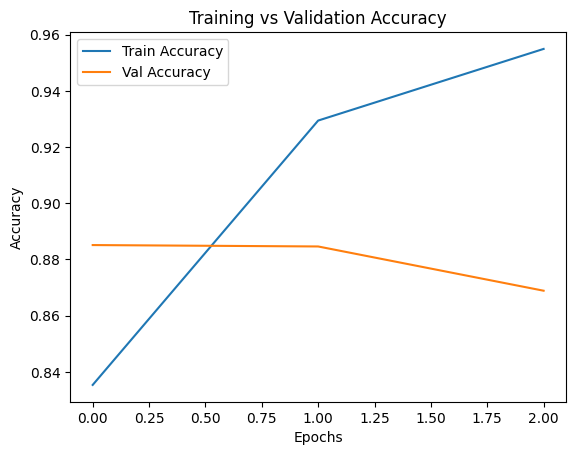

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.8733 - loss: 0.3377
Test Accuracy: 0.8744
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 91ms/step
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      4961
           1       0.91      0.84      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



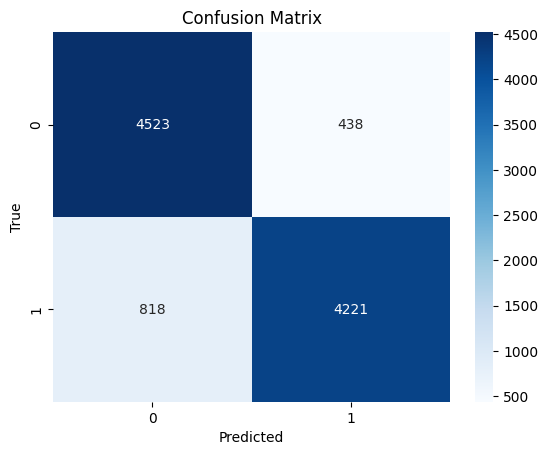

In [ ]:
# Evaluate
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {acc:.4f}")

# Predictions
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
model.save("lstm_imdb_model.h5")


In [ ]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(padded)[0][0]
    sentiment = "Positive" if pred >= 0.5 else "Negative"
    return sentiment, float(pred)

# Example
review = "This was one of the worst movies I've ever seen. The plot made no sense, the acting was wooden, and the dialogue was laughably bad. I kept waiting for it to get better, but it never did. A total waste of time."
predict_sentiment(review)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


('Negative', 0.0005106335156597197)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout

embedding_dim = 128

gru_model = Sequential()
gru_model.add(Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_len))
gru_model.add(GRU(units=128, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Build it before summary
gru_model.build(input_shape=(None, max_len))
gru_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,659,201 (10.14 MB)

 Trainable params: 2,659,201 (10.14 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

history_gru = gru_model.fit(
    X_train_pad, y_train,
    epochs=6,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop]
)


Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 123s 479ms/step - accuracy: 0.7124 - loss: 0.5439 - val_accuracy: 0.8589 - val_loss: 0.3335
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 117s 470ms/step - accuracy: 0.9182 - loss: 0.2152 - val_accuracy: 0.8796 - val_loss: 0.2909
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 116s 464ms/step - accuracy: 0.9539 - loss: 0.1392 - val_accuracy: 0.8758 - val_loss: 0.3327
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 461ms/step - accuracy: 0.9731 - loss: 0.0901 - val_accuracy: 0.8702 - val_loss: 0.4105


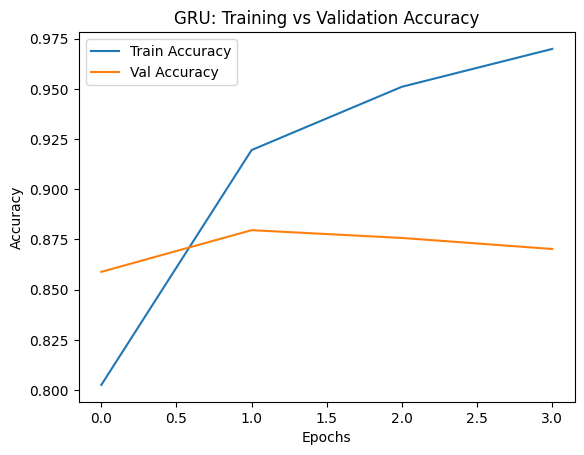

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title("GRU: Training vs Validation Accuracy")
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.8760 - loss: 0.3924
GRU Test Accuracy: 0.8708
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 58ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4961
           1       0.89      0.84      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



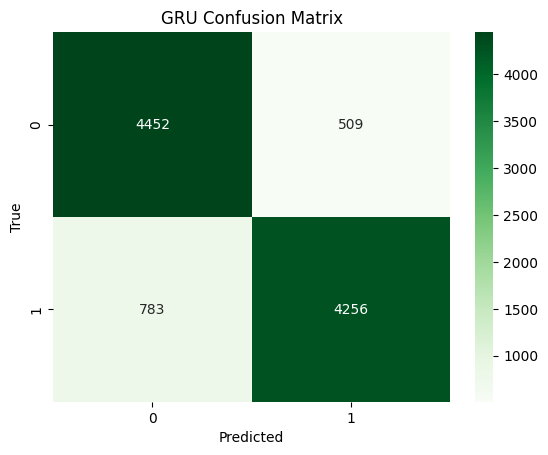

In [ ]:
# Evaluate
loss, acc = gru_model.evaluate(X_test_pad, y_test)
print(f"GRU Test Accuracy: {acc:.4f}")

# Predict
y_pred_gru = (gru_model.predict(X_test_pad) > 0.5).astype("int32")

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_test, y_pred_gru))

sns.heatmap(confusion_matrix(y_test, y_pred_gru), annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GRU Confusion Matrix')
plt.show()


In [ ]:
gru_model.save("gru_imdb_model.h5")


In [ ]:
def predict_gru_sentiment(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len)
    pred = gru_model.predict(padded)[0][0]
    sentiment = "Positive" if pred >= 0.5 else "Negative"
    return sentiment, float(pred)

# Example:
predict_gru_sentiment("Absolutely loved this movie! The story was engaging, the characters were well-developed, and the performances were outstanding. The direction and cinematography were top-notch. I was hooked from start to finish — highly recommended!")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


('Positive', 0.9996864199638367)